In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-10-18 17:41:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-18 17:41:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-18 17:41:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [8]:
# unzip the data
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [9]:
word2vec = {}
with open(os.path.join('glove.6B.200d.txt')) as f:

  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec


In [10]:
print(f'Found {len(word2vec)} word vectors')

Found 400000 word vectors


In [11]:
train = pd.read_csv('train.csv')

sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values

print('Max sequence length: ', max(len(s) for s in sentences))
print('Min sequence length: ', min(len(s) for s in sentences))

s = sorted(len(s) for s in sentences)
print('Median sequence length: ', s[len(s) // 2])

Max sequence length:  5000
Min sequence length:  6
Median sequence length:  205


In [12]:
# convert the sentences into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [13]:
# integer mapping 
word2idx = tokenizer.word_index
print(f'Found {len(word2idx)} unique tokens')

Found 210337 unique tokens


In [14]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)

Shape of data tensor:  (159571, 100)


In [15]:
# prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:      
      embedding_matrix[i] = embedding_vector

In [16]:
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

In [19]:
# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH, ))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

In [20]:
model = Model(input_, output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [22]:
history = model.fit(data, targets, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/10
998/998 [==============================] - 181s 182ms/step - loss: 0.0431 - accuracy: 0.9922 - val_loss: 0.1266 - val_accuracy: 0.9907
Epoch 2/10
998/998 [==============================] - 169s 169ms/step - loss: 0.0433 - accuracy: 0.9928 - val_loss: 0.1497 - val_accuracy: 0.9917
Epoch 3/10
998/998 [==============================] - 169s 169ms/step - loss: 0.0416 - accuracy: 0.9925 - val_loss: 0.1318 - val_accuracy: 0.9934
Epoch 4/10
998/998 [==============================] - 171s 171ms/step - loss: 0.0405 - accuracy: 0.9921 - val_loss: 0.1427 - val_accuracy: 0.9939
Epoch 5/10
998/998 [==============================] - 173s 174ms/step - loss: 0.0394 - accuracy: 0.9917 - val_loss: 0.1624 - val_accuracy: 0.9938
Epoch 6/10
998/998 [==============================] - 182s 182ms/step - loss: 0.0384 - accuracy: 0.9909 - val_loss: 0.1970 - val_accuracy: 0.9936
Epoch 7/10
998/998 [==============================] - 182s 183ms/step - loss: 0.0384 - accuracy: 0.9911 - val_loss: 0.1951 -

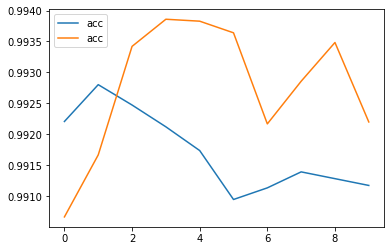

In [23]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='acc')
plt.legend()
plt.show()